In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Connect to DuckDB and run the query
plots = []

def execute_sql_query(sql, database='database.duck'):
    con = duckdb.connect(database=database)
    df = con.execute(sql).fetchdf()
    con.close()
    return df

def plot_distribution(ax, palette, show_legend, df, x, y, hue, title, x_label, y_label, legend_title, legend_loc, hue_order=None):
    sns.barplot(x=x, y=y, hue=hue, data=df, ax=ax, hue_order=hue_order, palette=palette)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend(title=legend_title, loc=legend_loc)
    if not show_legend:
        ax.get_legend().remove()

def make_lazy_plot(df, title, x_label, y_label, legend_title, legend_loc, x, y, hue, hue_order=None):
    return lambda ax, palette, show_legend: plot_distribution(ax, palette, show_legend, df, x, y, hue, title, x_label, y_label, legend_title, legend_loc, hue_order)

# Function to create a grid of plots
def make_grid(plots, width=10, height=8, style='seaborn-v0_8-whitegrid', color_palette='deep', n_colors=12):
    # Change the color scheme to a white background
    plt.style.use(style)
    num_plots = len(plots)
    rows = (num_plots + 1) // 2  # Calculate the number of rows needed
    fig = plt.figure(figsize=(width, height))  # Create a figure with the specified width and height
    gs = gridspec.GridSpec(rows, 2)  # Create a grid layout with the correct number of rows

    for i, plot in enumerate(plots):
        if i == num_plots - 1 and num_plots % 2 != 0:  # If it's the last plot and the number of plots is odd
            ax = fig.add_subplot(gs[i // 2, :])  # Span the last plot across two columns
        else:
            ax = fig.add_subplot(gs[i // 2, i % 2])
        plot(ax, sns.color_palette(color_palette, n_colors=n_colors))
    plt.tight_layout()
    plt.show()

def make_sequential_plots(plots, width=10, height=8, style='seaborn-v0_8-whitegrid', color_palette='deep', n_colors=12, global_legend=False):
    # Change the color scheme to a white background
    plt.style.use(style)
    fig, axs = plt.subplots(len(plots), 1, figsize=(width, height))
    for i, plot in enumerate(plots):
        plot(axs[i], sns.color_palette(color_palette, n_colors=n_colors), show_legend=(i==0))
    plt.tight_layout()
    plt.show()



In [2]:

df_ttr = execute_sql_query("""
WITH issues_raw AS (
    SELECT 
        project_id,
        state,
        created_at,
        closed_at
    FROM issues
),
issue_ttr AS (
    SELECT 
        project_id, state, 
        created_at, closed_at,
        EXTRACT(EPOCH FROM (closed_at - created_at)) AS ttr_seconds
    FROM issues_raw
    WHERE state = 'closed'    
),
bucketed_ttr AS (
    SELECT 
        project_id,
        CASE 
            WHEN ttr_seconds < 86400 THEN '0-1 dia'
            WHEN ttr_seconds >= 86400 AND ttr_seconds < 604800 THEN '1-7 dias'
            WHEN ttr_seconds >= 604800 AND ttr_seconds < 1296000 THEN '7-15 dias'
            WHEN ttr_seconds >= 1296000 AND ttr_seconds < 2592000 THEN '15-30 dias'
            WHEN ttr_seconds >= 2592000 AND ttr_seconds < 15552000 THEN '1-6 meses'
            ELSE '6+ meses'
        END AS bucket,
        CASE 
            WHEN ttr_seconds < 86400 THEN 1
            WHEN ttr_seconds >= 86400 AND ttr_seconds < 604800 THEN 2
            WHEN ttr_seconds >= 604800 AND ttr_seconds < 1296000 THEN 3
            WHEN ttr_seconds >= 1296000 AND ttr_seconds < 2592000 THEN 4
            WHEN ttr_seconds >= 2592000 AND ttr_seconds < 15552000 THEN 5
            ELSE 6
        END AS order_id
    FROM issue_ttr
    WHERE ttr_seconds >= 0
),
issue_count_per_project AS (
    SELECT 
        project_id,
        COUNT(*) AS count
    FROM bucketed_ttr
    GROUP BY project_id
),
raw_count AS (
    SELECT 
        project_id,
        bucket,
        COUNT(*) AS count,
        order_id
    FROM bucketed_ttr
    GROUP BY project_id, bucket, order_id
    ORDER BY project_id, order_id
)
SELECT 
    raw_count.project_id,
    raw_count.bucket,
    raw_count.count/project_count.count AS normalized_count,
    order_id
FROM raw_count
JOIN issue_count_per_project AS project_count
ON raw_count.project_id = project_count.project_id
ORDER BY raw_count.project_id, raw_count.order_id;
"""
)

plots.append(
    make_lazy_plot(
        df_ttr,
        title='Distribuição de tempo de resolução (TTR) por projeto',
        x_label='Tempo de resolução (TTR)',
        y_label='Frequencia Normalizada por total de issues',
        legend_title='ID do Projeto',
        legend_loc='upper right',
        x='bucket',
        y='normalized_count',
        hue='project_id'
    )
)


In [3]:
df_authors = execute_sql_query("""
WITH total_issues AS (
    SELECT
        project_id,
        count(*) AS total_issues
    FROM issues
    WHERE state = 'closed'
    GROUP BY project_id
),
issues_raw AS (
    SELECT
        project_id, author_association,
        count(*) AS total_association_issues
    FROM issues
    WHERE state = 'closed'
    GROUP BY project_id, author_association
)
SELECT
    t.project_id,
    t.total_issues,
    r.author_association,
    r.total_association_issues,
    r.total_association_issues/t.total_issues AS association_ratio
FROM total_issues t
JOIN issues_raw r
ON t.project_id = r.project_id
ORDER BY t.project_id, r.author_association;
""")

plots.append(
    make_lazy_plot(
        df_authors,
        title='Distribuição de Associação de Autores por Projeto',
        x_label='Associação de Autores do Issue',
        y_label='Frequencia Normalizada por total de issues',
        legend_title='ID do Projeto',
        legend_loc='upper left',
        x='author_association',
        y='association_ratio',
        hue='project_id'
    )
)

In [4]:
df_time_per_commit = execute_sql_query("""
WITH time_diffs AS (
    SELECT 
        project_id,
        EXTRACT(EPOCH FROM (commit.author.date - LAG(commit.author.date) OVER (PARTITION BY project_id ORDER BY commit.author.date))) AS time_diff
    FROM 
        commits
),
bucketed_time_diffs AS (
    SELECT 
        project_id,
        CASE 
            WHEN time_diff < 3600 THEN '0-1 hour'
            WHEN time_diff >= 3600 AND time_diff < 7200 THEN '1-2 horas'
            WHEN time_diff >= 7200 AND time_diff < 14400 THEN '2-4 horas'
            WHEN time_diff >= 14400 AND time_diff < 28800 THEN '4-8 horas'
            WHEN time_diff >= 28800 AND time_diff < 86400 THEN '8-24 horas'
            ELSE '24+ horas'
        END AS bucket,
        CASE 
            WHEN time_diff < 3600 THEN 1
            WHEN time_diff >= 3600 AND time_diff < 7200 THEN 2
            WHEN time_diff >= 7200 AND time_diff < 14400 THEN 3
            WHEN time_diff >= 14400 AND time_diff < 28800 THEN 4
            WHEN time_diff >= 28800 AND time_diff < 86400 THEN 5
            ELSE 6
        END AS order_id
    FROM time_diffs
    WHERE time_diff IS NOT NULL
),
commit_count_per_project AS (
    SELECT 
        project_id,
        COUNT(*) AS count
    FROM bucketed_time_diffs
    GROUP BY project_id
),
raw_count AS (
    SELECT 
        project_id,
        bucket,
        COUNT(*) AS count,
        order_id
    FROM bucketed_time_diffs
    GROUP BY project_id, bucket, order_id
    ORDER BY project_id, order_id
)
SELECT 
    raw_count.project_id,
    raw_count.bucket,
    raw_count.count / project_count.count AS normalized_count,
    order_id
FROM raw_count
JOIN commit_count_per_project AS project_count
ON raw_count.project_id = project_count.project_id
ORDER BY raw_count.project_id, raw_count.order_id;
""")

# Plot the distribution of time between commits for each project_id
plots.append(
    make_lazy_plot(
        df_time_per_commit,
        title='Distribuição de tempo entre commits por projeto',
        x_label='Tempo entre commits',
        y_label='Frequencia Normalizada por total de commits',
        legend_title='ID do Projeto',
        legend_loc='upper right',
        x='bucket',
        y='normalized_count',
        hue='project_id'
    )
)

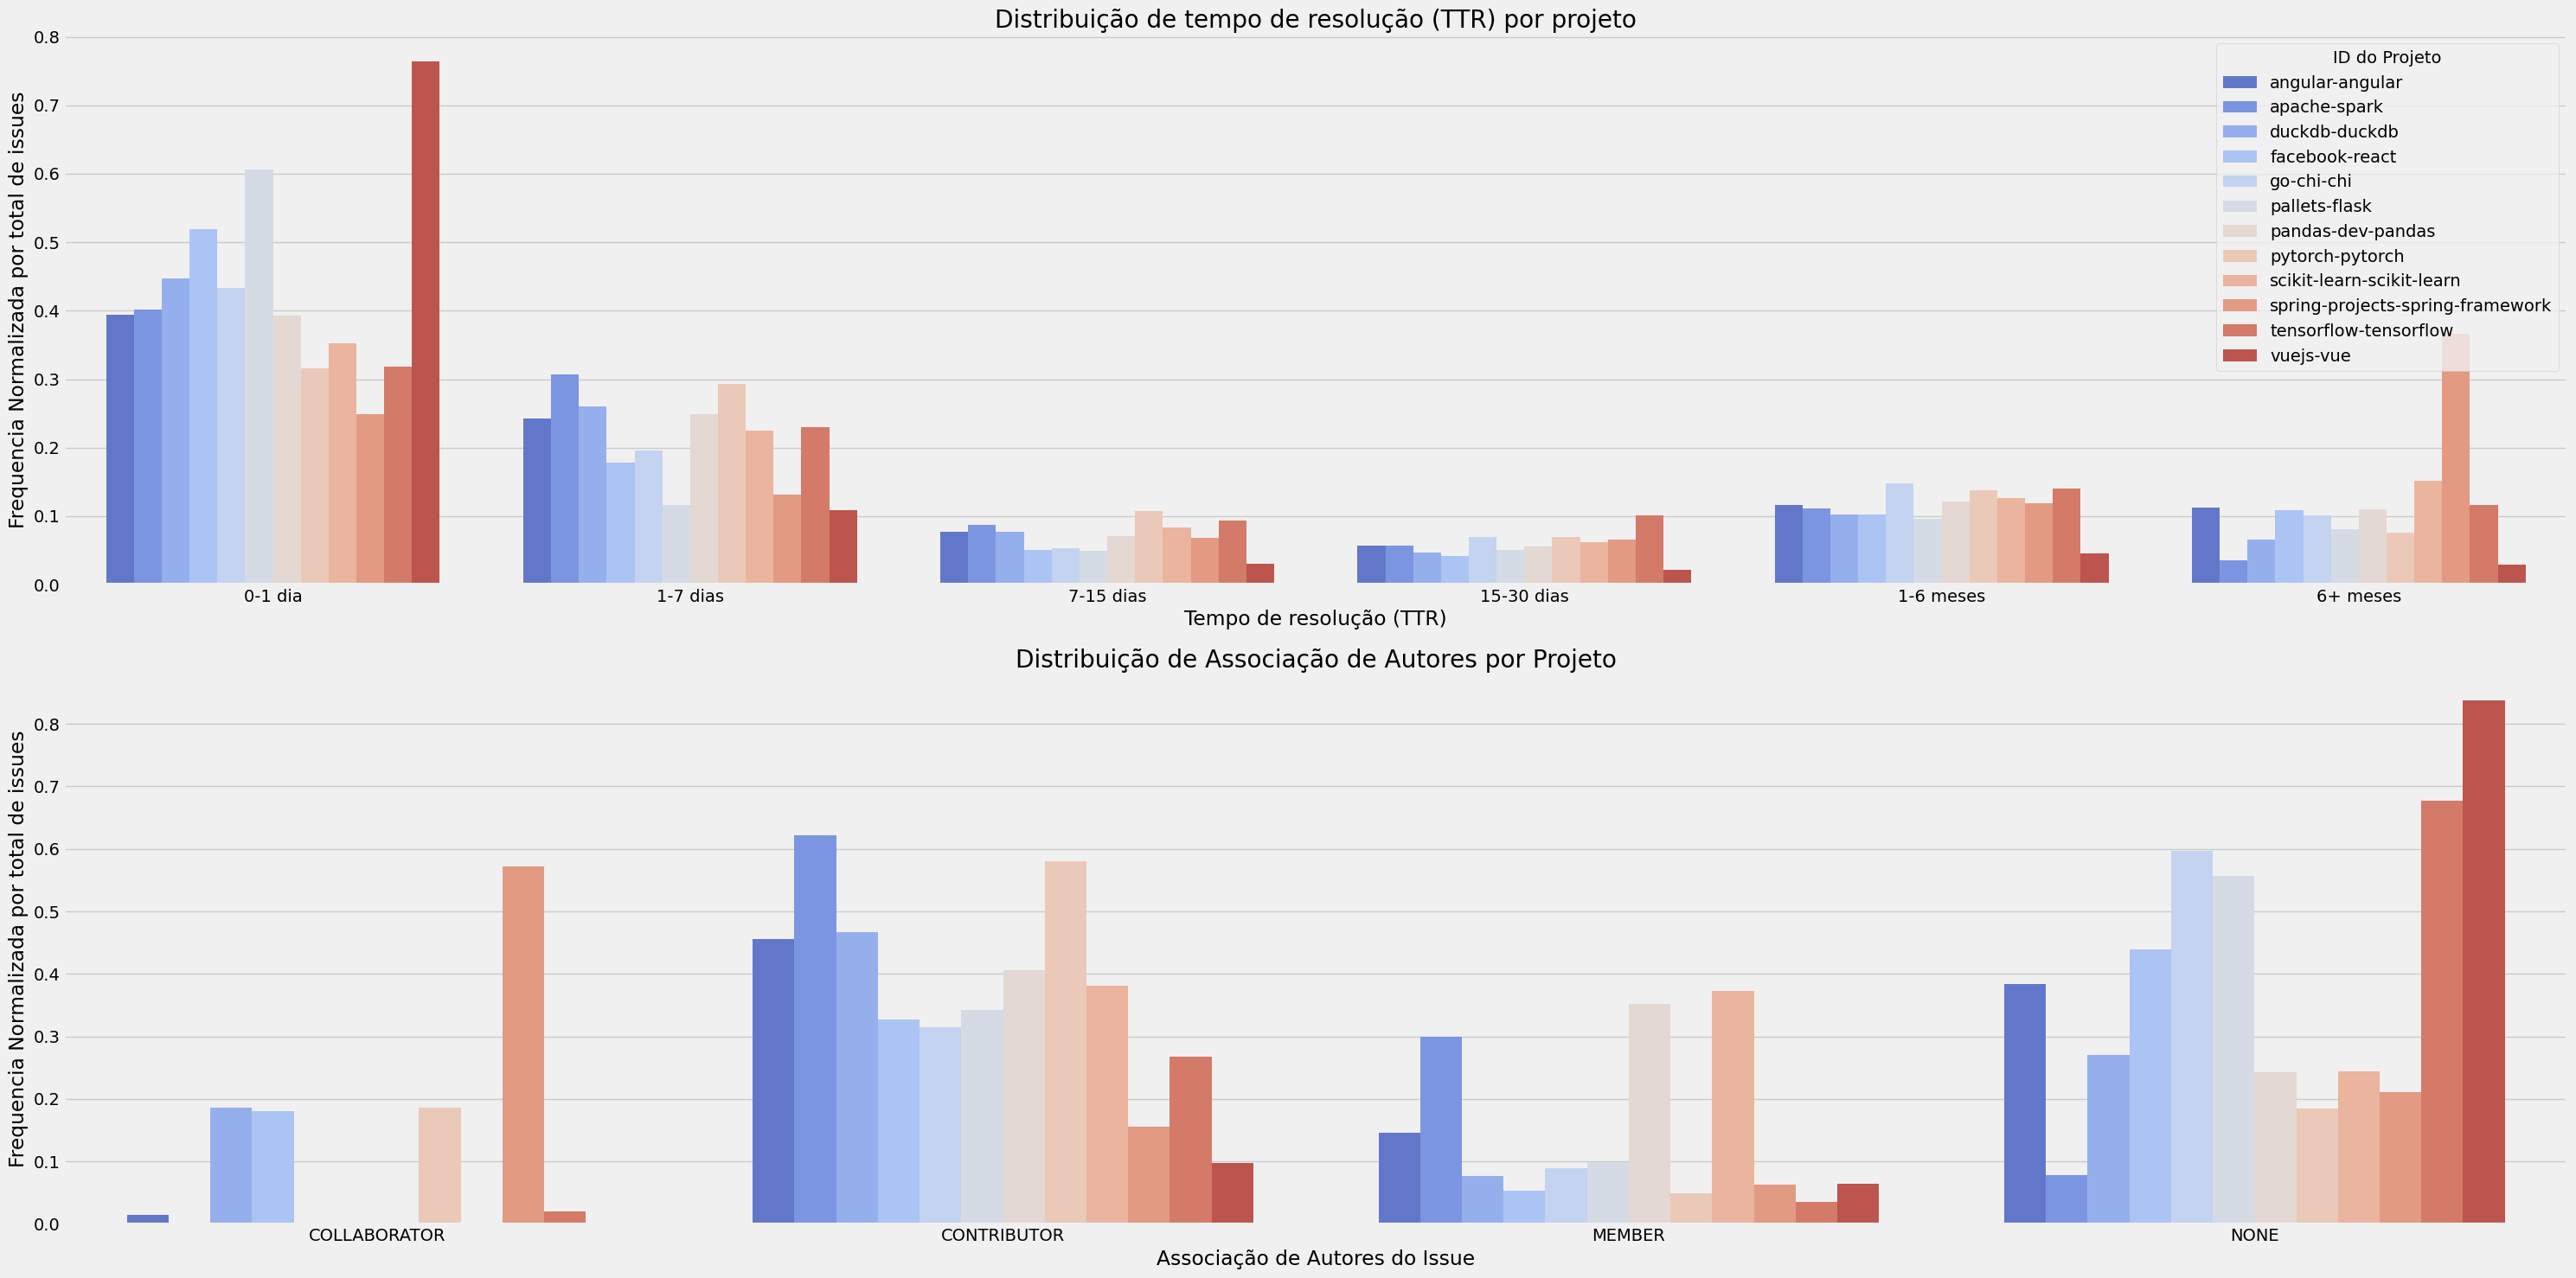

In [5]:

make_sequential_plots(plots[:-1], width=30, height=15, style='fivethirtyeight', color_palette='coolwarm')

In [6]:
# Other stats
df_ttr_up_to_30_days = df_ttr.loc[df_ttr['bucket'].isin(['0-1 dia', '1-7 dias', '7-15 dias', '15-30 dias'])]
df_ttr_up_to_30_days = df_ttr_up_to_30_days.groupby('project_id').sum()
df_ttr_up_to_30_days.normalized_count.mean()

np.float64(0.7734877887770506)

In [13]:
df_authors_mean = df_authors.loc[df_authors['author_association'].isin(['CONTRIBUTOR', 'NONE']) == False]
df_authors_mean = df_authors_mean.groupby('project_id').sum()
df_authors_mean.association_ratio.mean()

np.float64(0.2384686889278587)